<a href="https://colab.research.google.com/github/abrange/mit-deeplearning/blob/main/module_4/Deep_Learning_Mastering_Neural_Networks_Module_4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Mastering Neural Networks - Module 4 Asignment: CNN Classification of FashionMNIST Dataset

Now that we have Convolutional layers in our deep learning toolkit, we are going tackle a new and more challenging dataset - the [FashionMNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) dataset. This dataset is in a similar format to the MNIST dataset, however it contains images of different articles of clothing.

In this assignment, we ask that you develop a CNN classifier that implements **at least 2** convolutional layers.

A template has been provided below with some starter code and please feel free to reuse any code you have written or seen before in previous notebooks!



In [2]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Notice how FashionMNIST is also built into PyTorch!
fashion_mnist_train = torchvision.datasets.FashionMNIST('', train=True, transform =transform, download=True)

# We will split out train dataset into train and validation!
fashion_mnist_train, fashion_mnist_val = torch.utils.data.random_split(fashion_mnist_train, [int(np.floor(len(fashion_mnist_train)*0.75)), int(np.ceil(len(fashion_mnist_train)*0.25))])

fashion_mnist_test = torchvision.datasets.FashionMNIST('', train=False, transform = transform, download=True)

100.0%
100.0%
100.0%
100.0%


In [4]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(fashion_mnist_train, batch_size=batch_size),
               'val': DataLoader(fashion_mnist_val, batch_size=batch_size),
               'test': DataLoader(fashion_mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(fashion_mnist_train),
                 'val': len(fashion_mnist_val),
                 'test': len(fashion_mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


## Visualization

Before we go any further, we want to visualize the different datapoints in our dataset. Similar to the MNIST datset, there are 10 different object classes and they map to the following labels:

* 0 - T-shirt/top
* 1 - Trouser
* 2 - Pullover
* 3 - Dress
* 4 - Coat
* 5 - Sandal
* 6 - Shirt
* 7 - Sneaker
* 8 - Bag
* 9 - Ankle boot

Using the function below, we can visualize some of the different images that we will be working with from each class. Additionally, follow this [link](https://www.kaggle.com/datasets/zalando-research/fashionmnist) to find more information on the dataset.

In [5]:
# plot a digit ground truth and autoencoding
def view_fashionmnist(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # we only want to view a certain class
            if (labels[i] != label):
                continue
            # plot the ground truth
            ax = fig.add_subplot(1, count, idx)
            input = input.cpu().detach().numpy().reshape((28,28))
            ax.imshow(input, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

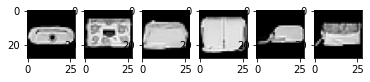

In [ ]:
# View 6 bags
view_fashionmnist(8, 6)

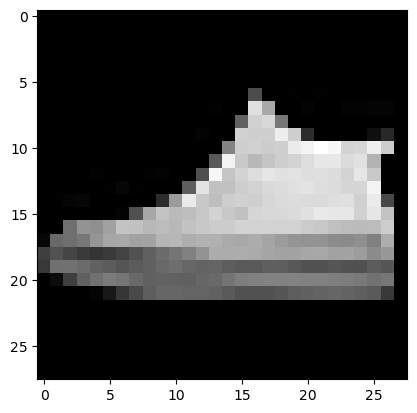

In [21]:
# View 1 sneaker
view_fashionmnist(7, 1)

In [41]:
def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch + 1}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves



### Visualizing Training Curves and Results

In [28]:
# Utility functions for plotting your results!
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


## Your Turn

Use what you have learned so far to develop a CNN classifier that implements **at least 2** convolutional layers.

In [22]:
# Hint! Create a CNNClassifier class that implements a forward function

# class CNNClassifier(nn.Module):
#     def __init__(self):
#         super(CNNClassifier, self).__init__()
#         # Split the Encoder and Decoder

#         self.pipeline =

#     def forward(self, x):
#         return self.pipeline(x)


## 1 Convolution Layer Model

In [32]:
from torch.nn.modules.flatten import Flatten
class OneCNNClassifier(nn.Module):
    def __init__(self):
        super(OneCNNClassifier, self).__init__()

        self.pipeline = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Linear(8*14*14, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.pipeline(x)


In [25]:
num_epochs = 10
learning_rate = 0.001
model = OneCNNClassifier().to(device)
print(model)

CNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1568, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [31]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
# Make sure you save the training curves along the way for visualization afterwards!
# model, training_curves = train_classification_model(...)

model, training_curves = train_classification_model(model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.2152 Acc: 0.9213
val   Loss: 0.2776 Acc: 0.9003
test  Loss: 0.2912 Acc: 0.8946

Epoch 2/10
----------
train Loss: 0.2010 Acc: 0.9269
val   Loss: 0.2749 Acc: 0.9021
test  Loss: 0.2893 Acc: 0.8970

Epoch 3/10
----------
train Loss: 0.1899 Acc: 0.9317
val   Loss: 0.2757 Acc: 0.9029
test  Loss: 0.2896 Acc: 0.8988

Epoch 4/10
----------
train Loss: 0.1790 Acc: 0.9353
val   Loss: 0.2751 Acc: 0.9029
test  Loss: 0.2901 Acc: 0.8970

Epoch 5/10
----------
train Loss: 0.1693 Acc: 0.9391
val   Loss: 0.2774 Acc: 0.9027
test  Loss: 0.2930 Acc: 0.8995

Epoch 6/10
----------
train Loss: 0.1605 Acc: 0.9421
val   Loss: 0.2806 Acc: 0.9029
test  Loss: 0.2967 Acc: 0.8996

Epoch 7/10
----------
train Loss: 0.1524 Acc: 0.9453
val   Loss: 0.2828 Acc: 0.9023
test  Loss: 0.2992 Acc: 0.8982

Epoch 8/10
----------
train Loss: 0.1448 Acc: 0.9491
val   Loss: 0.2842 Acc: 0.9026
test  Loss: 0.3007 Acc: 0.9004

Epoch 9/10
----------
train Loss: 0.1376 Acc: 0.9516
val   Loss: 0.2862

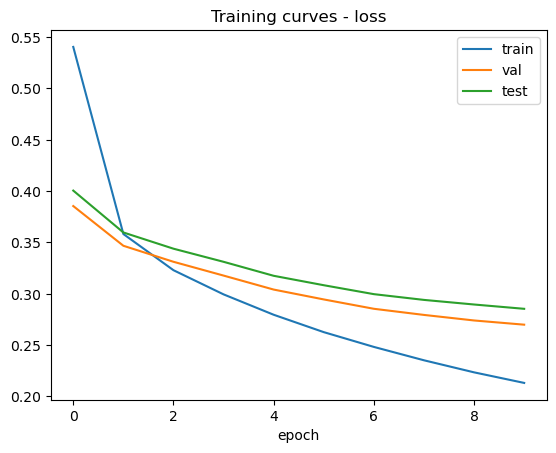

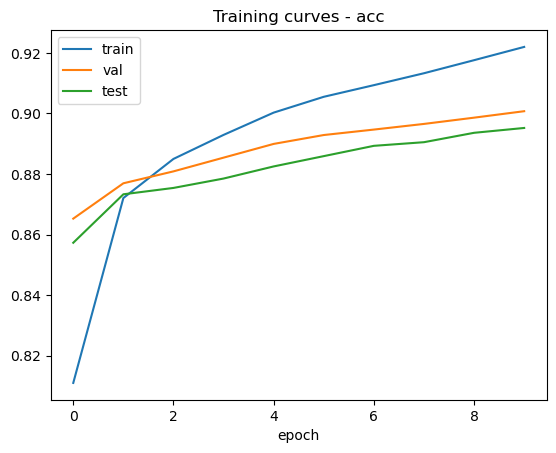

In [29]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

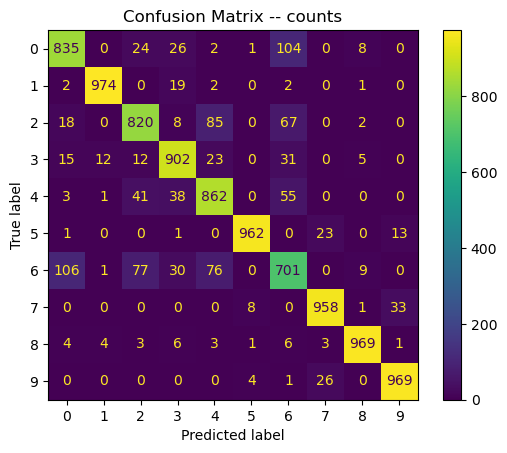

In [30]:
res = plot_cm(model, device, dataloaders, phase='test')

## Note about initial Conclusions

Now that we have implemented our network we want to examine the results.

What class of object is most often misclassified? What class is it incorrectly classified as most often?

Additionally, try re-training your network with dropout included. Does this help the performance or is there a noticeable change in the ability of the model to generalize? Is the most commonly misclassified object still the same as with no dropout?

## 2 Convolution Layer Model 

In [37]:
from torch.nn.modules.flatten import Flatten
class TwoCNNClassifier(nn.Module):
    def __init__(self):
        super(TwoCNNClassifier, self).__init__()

        self.pipeline = nn.Sequential(
            # First Convolutional
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size will be 8x14x14 (if input is 1x28x28)

            # Second Convolutional
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1), # Takes 8 channels, outputs 16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size will be 16x7x7 = 784

            nn.Flatten(),
            # Adjust the input features for the linear layer based on the new output size
            nn.Linear(16 * 7 * 7, 64), # 16 channels * 7x7 spatial dimensions
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.pipeline(x)


In [38]:
num_epochs = 10
learning_rate = 0.001
model = TwoCNNClassifier().to(device)
print(model)

TwoCNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=784, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [39]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
# Make sure you save the training curves along the way for visualization afterwards!
# model, training_curves = train_classification_model(...)

model, training_curves = train_classification_model(model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.6711 Acc: 0.7620
val   Loss: 0.4567 Acc: 0.8353
test  Loss: 0.4716 Acc: 0.8287

Epoch 2/10
----------
train Loss: 0.4125 Acc: 0.8520
val   Loss: 0.3917 Acc: 0.8591
test  Loss: 0.4055 Acc: 0.8558

Epoch 3/10
----------
train Loss: 0.3608 Acc: 0.8705
val   Loss: 0.3568 Acc: 0.8723
test  Loss: 0.3703 Acc: 0.8663

Epoch 4/10
----------
train Loss: 0.3299 Acc: 0.8814
val   Loss: 0.3277 Acc: 0.8823
test  Loss: 0.3427 Acc: 0.8768

Epoch 5/10
----------
train Loss: 0.3066 Acc: 0.8888
val   Loss: 0.3110 Acc: 0.8857
test  Loss: 0.3258 Acc: 0.8825

Epoch 6/10
----------
train Loss: 0.2885 Acc: 0.8952
val   Loss: 0.3023 Acc: 0.8873
test  Loss: 0.3166 Acc: 0.8848

Epoch 7/10
----------
train Loss: 0.2740 Acc: 0.9002
val   Loss: 0.2944 Acc: 0.8905
test  Loss: 0.3084 Acc: 0.8881

Epoch 8/10
----------
train Loss: 0.2618 Acc: 0.9045
val   Loss: 0.2896 Acc: 0.8925
test  Loss: 0.3024 Acc: 0.8891

Epoch 9/10
----------
train Loss: 0.2508 Acc: 0.9087
val   Loss: 0.2849

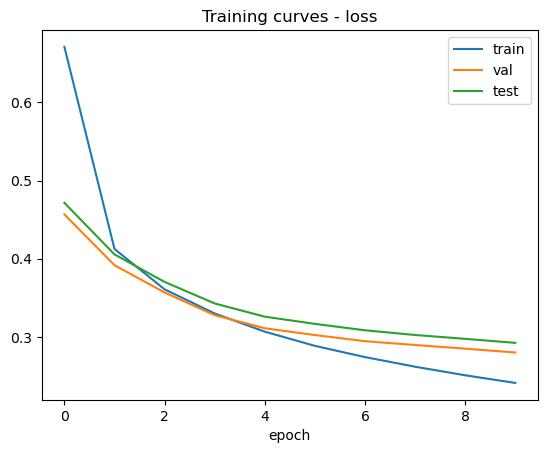

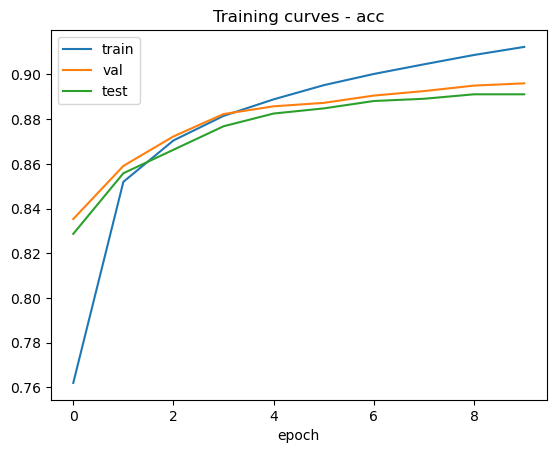

In [40]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

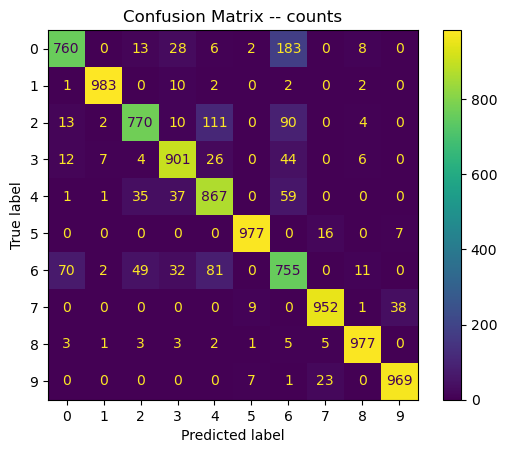

In [43]:
res = plot_cm(model, device, dataloaders, phase='test')

## 2 Convolution Layer Model, with Dropout

In [44]:
from torch.nn.modules.flatten import Flatten
class TwoCNNClassifierWithDropout(nn.Module):
    def __init__(self):
        super(TwoCNNClassifierWithDropout, self).__init__()

        self.pipeline = nn.Sequential(
            # First Convolutional
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size will be 8x14x14 (if input is 1x28x28)

            # Second Convolutional
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1), # Takes 8 channels, outputs 16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size will be 16x7x7 = 784
            
            # Add Dropout2d after the last pooling layer
            nn.Dropout2d(p=0.25), # Example dropout rate for conv layers

            nn.Flatten(),

            # Apply Dropout before the first dense layer
            nn.Dropout(p=0.5), # Standard dropout rate for fully connected layers
            
            # Adjust the input features for the linear layer based on the new output size
            nn.Linear(16 * 7 * 7, 64), # 16 channels * 7x7 spatial dimensions
            nn.ReLU(),
             
            # Apply Dropout before the last dense layer (or after the ReLU of the first)
            nn.Dropout(p=0.5), # Another dropout layer for regularization
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.pipeline(x)


In [45]:
num_epochs = 10
learning_rate = 0.001
model = TwoCNNClassifierWithDropout().to(device)
print(model)

TwoCNNClassifierWithDropout(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.25, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=784, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [46]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
# Make sure you save the training curves along the way for visualization afterwards!
# model, training_curves = train_classification_model(...)

model, training_curves = train_classification_model(model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.9398 Acc: 0.6611
val   Loss: 0.5217 Acc: 0.7977
test  Loss: 0.5362 Acc: 0.7909

Epoch 2/10
----------
train Loss: 0.6363 Acc: 0.7697
val   Loss: 0.4563 Acc: 0.8301
test  Loss: 0.4732 Acc: 0.8196

Epoch 3/10
----------
train Loss: 0.5862 Acc: 0.7878
val   Loss: 0.4290 Acc: 0.8398
test  Loss: 0.4459 Acc: 0.8325

Epoch 4/10
----------
train Loss: 0.5590 Acc: 0.7989
val   Loss: 0.4083 Acc: 0.8503
test  Loss: 0.4238 Acc: 0.8429

Epoch 5/10
----------
train Loss: 0.5350 Acc: 0.8048
val   Loss: 0.3887 Acc: 0.8533
test  Loss: 0.4053 Acc: 0.8467

Epoch 6/10
----------
train Loss: 0.5225 Acc: 0.8115
val   Loss: 0.3813 Acc: 0.8569
test  Loss: 0.3998 Acc: 0.8477

Epoch 7/10
----------
train Loss: 0.5107 Acc: 0.8149
val   Loss: 0.3726 Acc: 0.8590
test  Loss: 0.3922 Acc: 0.8538

Epoch 8/10
----------
train Loss: 0.5041 Acc: 0.8194
val   Loss: 0.3676 Acc: 0.8624
test  Loss: 0.3863 Acc: 0.8576

Epoch 9/10
----------
train Loss: 0.4914 Acc: 0.8222
val   Loss: 0.3575

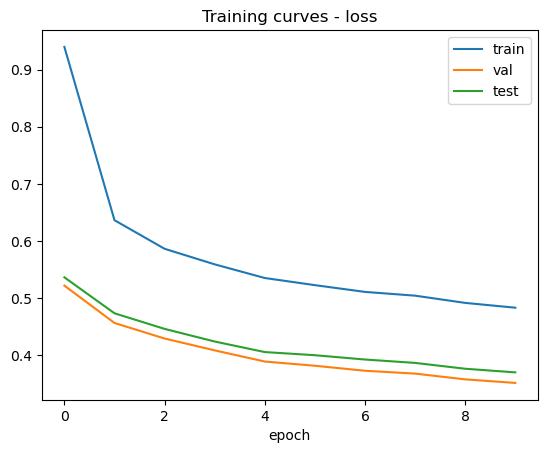

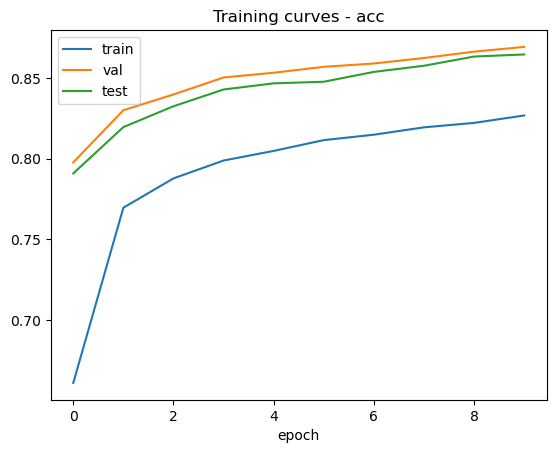

In [47]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

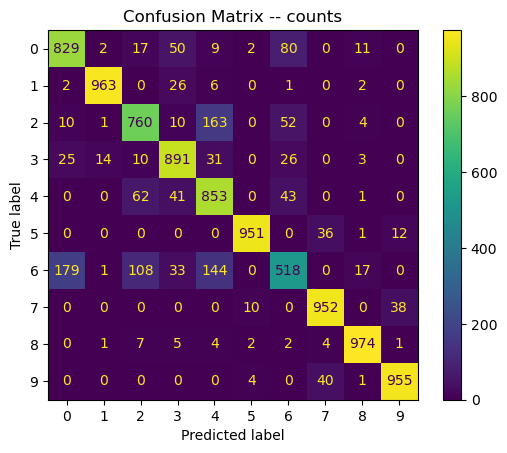

In [50]:
res = plot_cm(model, device, dataloaders, phase='test')

## Final Assignments Conclusions

What class of object is most often misclassified? What class is it incorrectly classified as most often?

Additionally, try re-training your network with dropout included. Does this help the performance or is there a noticeable change in the ability of the model to generalize? Is the most commonly misclassified object still the same as with no dropout?